In [1]:
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array,array_to_img,ImageDataGenerator
import matplotlib.pyplot as Plt
import keras
from keras import metrics
from keras.models import Sequential,Model,load_model,model_from_json
from keras.layers import Dense,Activation,Input
from keras.layers import Conv2D, Flatten
from keras.layers import MaxPooling2D,Dropout
import numpy as np
import json
import pprint
from sklearn.cross_validation import train_test_split
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

from PIL import Image

Using TensorFlow backend.
/usr/local/src/pyenv/versions/latest_mod/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
k=1367
width=480
height=640

gominum=7
xywhc=5


In [4]:

x=np.load("x.npy")
y=np.load("y.npy")
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)


y_xywh_train=np.zeros((len(y_train),gominum,4))
y_c_train=np.zeros((len(y_train),gominum))
for i in range(len(y_train)):
    for j in range(len(y_train[0])):
        y_xywh_train[i][j]=y_train[i][j][:4]
        if(y_train[i][j][4]==1):
            y_c_train[i][j]=1
            

y_xywh_test=np.zeros((len(y_test),gominum,4))
y_c_test=np.zeros((len(y_test),gominum))                      
for i in range(len(y_test)):
    for j in range(len(y_test[0])):
        y_xywh_test[i][j]=y_test[i][j][:4]
        if(y_test[i][j][4]==1):
            y_c_test[i][j]=1

for i in range(len(y_xywh_train)):
    for j in range(len(y_xywh_train[0])):
        y_xywh_train[i][j][0]= y_xywh_train[i][j][0]/480
        y_xywh_train[i][j][1]= y_xywh_train[i][j][1]/640
        y_xywh_train[i][j][2]= y_xywh_train[i][j][2]/300
        y_xywh_train[i][j][3]= y_xywh_train[i][j][3]/300
            
x_train=x_train.astype('float32')/255
x_test=x_test.astype('float32')/255
#y_train=y_train.reshape(-1,35)
#y_test=y_test.reshape(-1,35)
y_xywh_train=y_xywh_train.reshape(-1,28).astype('float32')/1000
y_xywh_test=y_xywh_test.reshape(-1,28).astype('float32')/1000

y_c_train=y_c_train.reshape(-1,7)
y_c_test=y_c_test.reshape(-1,7)


[ 0.1389765   0.2808809   0.06122483  0.1244379   0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.        ]


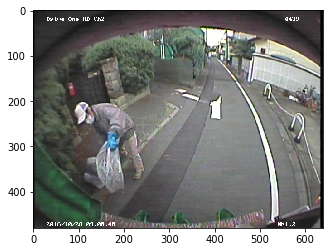

In [5]:

plt.imshow(x_train[14])
print(y_xywh_train[14])



In [6]:

vgg16 = VGG16(include_top=False, weights='imagenet' ,input_shape=(width,height,3))
inputs=vgg16.output

batch_size=1
epoch=10
#inputs =Input(shape=(width,height,3))
#x=Conv2D(16,kernel_size=(3,3),activation='relu')(inputs)
#x=Conv2D(16,kernel_size=(3,3),activation='relu')(x)
#x=MaxPooling2D(pool_size=(2,2))(x)
#x=Dropout(0.25)(x)
x=Flatten()(inputs)


main_output=Dense(28,activation='softmax',name='main_output')(x)
side_output=Dense(7, activation='sigmoid',name='side_output')(x)

model = Model(inputs=vgg16.input, outputs=[main_output, side_output])



model.compile(optimizer="sgd",loss={'main_output': 'mean_squared_error', 'side_output': 'binary_crossentropy'},
              metrics={'main_output': 'mae', 'side_output': 'accuracy'})


image = Image.open("1/14.jpg")

data = np.asarray(image, dtype=float)
data = data.reshape(1,480,640,3)
testdata=model.predict(data)
print(testdata)

[array([[  4.07369888e-10,   2.27246932e-09,   2.83960442e-12,
          4.09313944e-10,   1.17724053e-09,   5.52198998e-08,
          1.10337026e-16,   1.61988203e-06,   3.43182869e-08,
          9.22640125e-15,   2.44150928e-04,   3.44163142e-10,
          3.68274442e-14,   1.73701539e-11,   2.54966726e-04,
          2.69093905e-02,   2.04390332e-07,   9.72555697e-01,
          9.40265865e-10,   7.93617346e-06,   6.60961632e-07,
          5.50872046e-17,   1.50406887e-09,   1.23922209e-05,
          4.71125122e-06,   7.58095392e-11,   3.97147454e-11,
          8.25876214e-06]], dtype=float32), array([[  1.33578491e-04,   9.99011517e-01,   3.56709778e-01,
          9.99887228e-01,   9.91370320e-01,   8.02901515e-04,
          4.55584712e-02]], dtype=float32)]


In [ ]:
model.fit(x=x_train,y=[y_xywh_train,y_c_train],batch_size=batch_size,epochs=epoch,verbose=1,
          validation_data=(x_test,[y_xywh_test,y_c_test]))
model.evaluate(x_test,[y_xywh_test,y_c_test],verbose=1)



In [ ]:
json_string = model.to_json()
open('model.json', 'w').write(json_string)
model.save('model.h5') 
model.save_weights('param.hdf5')